In [1]:
import requests
import json
from datetime import datetime
import enum 

class Code(enum.Enum):
    TYPICAL_MEAL  = 66
    PRE_SNACK = 64
    
    POST_SUPPER = 63
    PRE_SUPPER = 62
    
    POST_LUNCH = 61
    PRE_LUNCH = 60
    
    POST_BREAKFAST = 59
    PRE_BREAKFAST = 58



_BASE_LOCATION = "https://telehealth.ait.ac.th:5000/api/v1/"
_API_KEY = "a3fca5e7b8d1e2f3c4a5b6d7e8f9g0a1b2c3d4e5f6a7b8c9d0e1f2a3b4c5d6e7"

def fetch_by_user_id(user_id:int, start_date:datetime, end_date:datetime):
    endpoint:str = "get_blood_sugar"
    url:str = f"{_BASE_LOCATION}{endpoint}"

    payload = json.dumps({
        "patient_id": user_id,
        "date_time_start": start_date.strftime("%Y-%m-%d"),
        "date_time_end": end_date.strftime("%Y-%m-%d")
    })
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': _API_KEY
    }

    response = requests.request("POST", url, headers=headers, data=payload)

    return json.loads(response.text)


In [16]:
start_date = datetime(year=2025, month=10, day=31)
end_date = datetime(year=2025, month=10, day=31)
fetch_by_user_id(user_id=10, start_date=start_date, end_date=end_date)

{'status': 200,
 'date_time_start': '2025-10-31 00:00:00',
 'date_time_end': '2025-10-31 23:59:59',
 'message': 'success',
 'data': [{'RecordID': 12585,
   'PatientID': 10,
   'RecordDate': '2025-10-31',
   'RecordTime': '07:30:00',
   'Code': 58,
   'Value': 92,
   'RecordDT': '2025-10-31 07:30:00',
   'Description': 'Pre-breakfast blood glucose measurement'},
  {'RecordID': 12576,
   'PatientID': 10,
   'RecordDate': '2025-10-31',
   'RecordTime': '07:30:00',
   'Code': 58,
   'Value': 92,
   'RecordDT': '2025-10-31 07:30:00',
   'Description': 'Pre-breakfast blood glucose measurement'},
  {'RecordID': 12549,
   'PatientID': 10,
   'RecordDate': '2025-10-31',
   'RecordTime': '08:00:00',
   'Code': 58,
   'Value': 60,
   'RecordDT': '2025-10-31 08:00:00',
   'Description': 'Pre-breakfast blood glucose measurement'},
  {'RecordID': 12550,
   'PatientID': 10,
   'RecordDate': '2025-10-31',
   'RecordTime': '08:12:00',
   'Code': 58,
   'Value': 95,
   'RecordDT': '2025-10-31 08:12:00',

In [2]:
def post_glucose(user_id:int, code:Code, value:float, created_date:datetime):
    endpoint:str = "diabetesrecords"
    url:str = f"{_BASE_LOCATION}{endpoint}"

    payload = json.dumps({
        "PatientID": user_id,
        "Code": code.value,
        "Value": value,
        "RecordDT": created_date.strftime("%Y-%m-%d %H:%M:%S")
    })
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': _API_KEY
    }

    response = requests.request("POST", url, headers=headers, data=payload)

    return json.loads(response.text)

In [3]:

post_glucose(user_id=12, code=Code.POST_BREAKFAST, value=100, created_date=datetime.now())

{'status': 200,
 'message': 'Created',
 'input': {'PatientID': 12,
  'Code': 59,
  'Value': 100,
  'RecordDT': '2025-11-19 17:28:13'},
 'data': {'RecordID': 12593,
  'PatientID': 12,
  'RecordDate': '2025-11-19',
  'RecordTime': '17:28:13',
  'Code': 59,
  'Value': 100,
  'RecordDT': '2025-11-19 17:28:13',
  'Description': 'Post-breakfast blood glucose measurement'}}

In [8]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.envfiles/dev.env")
async def get_raman_shift() -> list[float]:
    from src.db import OptoFile
    from datetime import datetime

    created = datetime.strptime("2025-09-25 08:16:44", "%Y-%m-%d %H:%M:%S")
    optofile = await OptoFile.fetch(subject_id='s1', created=created)
    return optofile.raman_shift

async def create_sample(spectrum:list[float]):
    from src.spectra import Sample
    import numpy as np
    from rampy import baseline as rbaseline

    raman_shift:list[float] = await get_raman_shift()
    sample:Sample = Sample(
        x=np.array(raman_shift),
        y=np.array(spectrum),
        interpolate=False,
        verbose=True
    )
    sample.despike(window_length=10,threshold=5)
    sample.interpolate(step=1)
    sample.extract_range(low=750, high=1650)
    sample.smoothing(window_length=60, polyorder=1)
    signal_y, by = rbaseline(sample.x, sample.y, roi=[[905, 915],[1050, 1070],[1100, 1150],[1400,1460]])
    sample.y = signal_y.reshape(-1)
    # f911  = sample.at(np.arange(905, 915)).mean()
    # f1060 = sample.at(np.arange(1050, 1070)).mean()
    # f1125 = sample.at(np.arange(1125, 1170)).mean()
    # f1450 = sample.at(np.arange(1440, 1460)).mean()
    sample.normalized(method='minmax')
    sample.extract_range(low=800, high=1600)
    return sample

In [11]:
spectrum = [
    389.1032,
    393.2731,
    397.6122,
    402.1241,
    406.8122,
    411.6802,
    416.7316,
    421.97,
    427.3991,
    757.4227,
    877.8443,
    551.8677,
    595.6967,
    487.735,
    587.3865,
    732.6549,
    328.3441,
    569.258,
    728.8004,
    591.9752,
    401.7864,
    400.8379,
    509.1336,
    584.4776,
    551.0737,
    338.1259,
    357.0384,
    592.215,
    574.0599,
    611.577,
    768.1704,
    699.2442,
    847.6024,
    976.8491,
    901.3883,
    995.2242,
    924.1607,
    958.8021,
    1032.7523,
    785.0155,
    1014.1958,
    1078.8972,
    858.1239,
    722.6342,
    756.6302,
    1198.9141,
    1111.4879,
    1008.7537,
    1457.1132,
    1434.3686,
    1255.3216,
    1353.1741,
    1557.3278,
    1357.5845,
    858.9458,
    1086.4132,
    1407.3884,
    1193.0727,
    1336.4677,
    1431.3747,
    1602.195,
    1524.9298,
    1519.1803,
    1323.1476,
    1074.8327,
    1369.2366,
    1233.1601,
    642.8042,
    940.5694,
    1117.4566,
    1132.6665,
    1344.7997,
    1340.2567,
    1159.8378,
    1345.9433,
    1479.5735,
    1105.7286,
    946.8087,
    911.2137,
    1046.3438,
    960.1987,
    700.7782,
    684.4824,
    628.3115,
    737.2656,
    737.9447,
    955.5488,
    949.0776,
    899.5311,
    714.309,
    840.4109,
    787.2364,
    672.585,
    966.2565,
    1092.4502,
    1052.3654,
    1114.6014,
    1288.1572,
    1117.232,
    1291.0246,
    1404.534,
    1316.959,
    1337.0984,
    1252.9508,
    1049.1148,
    992.1889,
    1169.9717,
    873.8809,
    1120.8952,
    987.8128,
    749.0351,
    972.3571,
    805.3787,
    804.1006,
    764.1218,
    767.8401,
    940.4549,
    1037.763,
    871.3627,
    1018.4755,
    1095.6863,
    940.7832,
    840.5634,
    899.6246,
    962.764,
    914.1787,
    758.0659,
    705.4223,
    884.0448,
    924.3301,
    913.4968,
    929.7194,
    1106.7959,
    980.7206,
    687.4896,
    823.0988,
    838.9442,
    756.2218,
    570.1272,
    591.6562,
    888.4035,
    618.3743,
    582.7528,
    528.5417,
    716.5289,
    604.3093,
    465.4407,
    683.8115,
    616.7699,
    548.1991,
    718.2883,
    602.195,
    649.4992,
    844.4603,
    845.99,
    804.62,
    773.5387,
    750.674,
    601.6321,
    407.1651,
    304.6829,
    869.3441,
    574.754,
    671.2996,
    768.7647,
    799.3387,
    750.2183,
    834.9927,
    788.853,
    932.9352,
    824.1507,
    729.1502,
    786.6569,
    420.9925,
    580.5608,
    698.1492,
    606.1802,
    541.999,
    538.6305,
    487.5928,
    459.5064,
    328.9166,
    441.0689,
    390.2221,
    165.3082,
    338.7402,
    108.5904,
    0,
    208.3221,
    110.6562,
    4.4164,
    21.4415,
    116.499,
    254.2173,
    57.3481,
    27.0487,
    0,
    97.1136,
    105.9442,
    0,
    0,
    122.5262,
    15.1184,
    33.6721,
    138.8415,
    225.5595,
    187.3285,
    106.9336,
    156.1314,
    143.2806,
    0,
    39.0593,
    0,
    18.8478,
    124.0573,
    108.4677,
    113.6875,
    155.6574,
    119.1389,
    61.3507,
    52.1906,
    0,
    56.8869,
    0,
    93.6104,
    170.4,
    42.6987,
    0,
    0,
    193.0391,
    122.4023,
    0,
    91.5649,
    37.2318,
    85.7864,
    79.769,
    104.4884,
    76.2407,
    63.3091,
    36.9238,
    66.1503,
    130.3153,
    30.9348,
    0,
    90.3894,
    0,
    0,
    364.3153,
    75.9198,
    51.2409,
    105.8676,
    227.4384,
    0,
    86.6047,
    108.5924,
    29.0478,
    135.1248,
    32.7244,
    271.1523,
    243.1861,
    0,
    108.9778,
    185.9949,
    38.1726,
    237.3402,
    190.2555,
    0,
    20.9139,
    277.8771,
    94.0436,
    27.5962,
    0,
    162.4268,
    0,
    162.9154,
    125.3153,
    198.3853,
    67.0324,
    68.0225,
    159.157,
    4.3129,
    47.7083,
    161.1469,
    170.2497,
    85.0081,
    94.3812,
    133.439,
    126.7917,
    377.3236,
    0,
    62.5853,
    89.8945,
    72.7416,
    27.7249,
    131.2886,
    199.0708,
    23.7942,
    109.898,
    89.5315,
    80.147,
    205.1158,
    50.2735,
    163.4819,
    220.7541,
    48.583,
    9.1761,
    72.7993,
    537.6962,
    91.0875,
    187.5337,
    178.9195,
    184.11,
    289.6235,
    203.6811,
    119.5374,
    182.9653,
    177.9686,
    0,
    42.1711,
    156.8727,
    154.7884,
    300.2947,
    247.2439,
    272.7625,
    231.4692,
    260.0397,
    107.8357,
    148.6467,
    318.8107,
    234.6025,
    360.5262,
    348.6547,
    302.3816,
    204.965,
    182.1995,
    175.0739,
    352.924,
    347.1991,
    271.6106,
    249.6725,
    172.6061,
    178.9545,
    207.8746,
    313.2225,
    346.3126,
    196.6468,
    221.7164,
    119.4236,
    121.4981,
    235.272,
    41.0513,
    166.5885,
    180.5499,
    218.7654,
    129.1223,
    132.8469,
    29.7217,
    67.3299,
    90.5832,
    31.3115,
    104,
    10.4364,
    167.7815,
    250.5025,
    358.7511,
    0,
    0,
    362.8799,
    79.2116,
    185.6236,
    307.0159,
    163.1909,
    58.9418,
    200.9033,
    93.9911,
    0,
    266.9736,
    170.5329,
    25.3941,
    72.9045,
    72.0387,
    215.842,
    255.8519,
    97.7552,
    0,
    100.1471,
    138.948,
    75.3249,
    134.6885,
    124.1789,
    117.0588,
    290.6532,
    133.1456,
    3.5392,
    129.8366,
    179.6351,
    62.5385,
    132.5451,
    201.8562,
    156.8057,
    136.9648,
    257.7284,
    308.949,
    180.9514,
    236.6507,
    361.5997,
    335.6675,
    127.6357,
    115.4189,
    230.8409,
    287.0394,
    279.4214,
    161.0217,
    177.856,
    314.5324,
    199.6182,
    293.9487,
    326.3136,
    129.3603,
    324.8872,
    287.0748,
    162.7207,
    179.4304,
    115.618,
    272.2698,
    270.2046,
    126.0214,
    303.1026,
    328.4484,
    173.8644,
    158.7442,
    253.4799,
    213.637,
    226.013,
    328.6097,
    493.6289,
    311.8739,
    266.1451,
    413.6445,
    258.3747,
    240.7386,
    264.7431,
    396.7887,
    475.4767,
    382.4107,
    373.7935,
    300.6273,
    416.9677,
    269.8024,
    315.0937,
    406.2426,
    424.4539,
    434.1338,
    399.8728,
    323.0708,
    273.5546,
    374.4968,
    485.7035,
    231.1719,
    194.8952,
    353.0729,
    311.7039,
    95.5872,
    281.5216,
    185.5058,
    260.5384,
    265.023,
    129.5536,
    296.1294,
    380.3495,
    65.4131,
    213.5196,
    281.2686,
    192.8635,
    339.5001,
    272.812,
    171.3309,
    238.0903,
    318.0895,
    311.3279,
    259.0629,
    171.6925,
    238.4443,
    262.3397,
    312.0989,
    428.7471,
    429.497,
    295.2833,
    436.9273,
    383.4229,
    326.0908,
    282.2523,
    269.7148,
    298.5911,
    721.6089,
    323.8931,
    473.7084,
    524.9772,
    434.7863,
    393.0156,
    469.8279,
    501.8196,
    379.7865,
    279.1342,
    293.0398,
    382.1235,
    279.2147,
    197.7135,
    241.6188,
    303.1298,
    335.2456,
    189.7652,
    141.3645,
    31.8892,
    90.0151,
    125.7403,
    2.465,
    119.7885,
    56.11,
    26.6274,
    91.9373,
    0,
    0,
    114.0305,
    218.2995,
    117.9098,
    185.1106,
    161.4807,
    51.0776,
    86.1213,
    104.1193,
    0,
    0,
    66.5039,
    124.2182,
    0,
    21.8364,
    43.5027,
    0,
    148.5725,
    72.0573,
    119.3069,
    40.9558,
    68.9275,
    114.0194,
    82.2811,
    164.7182,
    104.0883,
    56.6423,
    87.1806,
    81.9032,
    25.2102,
    199.9001,
    0,
    125.233,
    186.4761,
    98.8999,
    46.3119,
    112.2747,
    105.8562,
    141.4226,
    57.974,
    118.3108,
    135.3818,
    188.9817,
    212.6824,
    121.2622,
    111.7999,
    138.4694,
    161.6569,
    213.4272,
    188.3581,
    266.2555,
    293.198,
    177.0546,
    0,
    230.0266,
    373.6832,
    265.6868,
    262.3721,
    373.6159,
    346.5306,
    335.6353,
    478.3666,
    364.127,
    437.3265,
    494.3521,
    576.0259,
    575.727,
    344.2252,
    298.5203,
    545.3578,
    417.4467,
    438.9327,
    457.6161,
    292.4205,
    454.7596,
    496.2371,
    257.3144,
    255.9906,
    436.4657,
    420.94,
    239.9189,
    318.9961,
    312.0751,
    211.3539,
    328.8345,
    292.7172,
    204.8028,
    242.0921,
    269.1852,
    119.2825,
    201.3843,
    269.5773,
    69.118,
    139.0469,
    0,
    0,
    166.9443,
    117.7084,
    7.6744,
    77.044,
    101.6185,
    110.9942,
    131.2978,
    112.6794,
    113.6619,
    61.6453,
    70.0262,
    43.2432,
    13.6219,
    38.9994,
    0,
    79.7716,
    190.5551,
    105.9566,
    145.3513,
    0,
    9.7458,
    118.7399,
    118.9268,
    45.3194,
    55.9078,
    0,
    102.8886,
    145.8695,
    77.8293,
    67.383,
    86.5299,
    170.2692,
    108.0006,
    112.1239,
    106.8375,
    27.3413,
    0,
    0,
    64.7665,
    100.4271,
    121.1618,
    121.6846,
    55.4991,
    35.3003,
    81.8915,
    148.5371,
    72.6945,
    0,
    40.6085,
    90.5524,
    121.9159,
    126.6367,
    0,
    72.3528,
    91.0286,
    61.7034,
    80.5368,
    112.9352,
    196.7476,
    141.2494,
    111.0541,
    123.6531,
    168.7823,
    139.1559,
    150.5005,
    119.4293,
    31.0676,
    89.5609,
    140.4636,
    136.5483,
    72.3486,
    118.0904,
    160.3847,
    2.0474,
    29.1211,
    100.4652,
    131.2232,
    42.1058,
    72.443,
    72.1618,
    11.1336,
    35.5809,
    95.3918,
    70.0944,
    108.8388,
    79.3452,
    4.4173,
    134.8951,
    171.003,
    237.1896,
    0,
    71.8865,
    188.1383,
    90.5252,
    0,
    40.2276,
    101.4264,
    0,
    2.2458,
    288.8682,
    117.262,
    79.4863,
    58.7534,
    109.3747,
    59.5515,
    74.3013,
    66.2259,
    66.9078,
    137.0899,
    171.4829,
    0,
    46.7384,
    37.8009,
    115.6174,
    70.1796,
    32.146,
    112.5386,
    99.6851,
    132.0763,
    157.458,
    55.5223,
    171.6238,
    225.6544,
    129.8182,
    90.3558,
    115.0406,
    135.0366,
    70.0565,
    122.4371,
    79.1318,
    42.2256,
    116.1567,
    124.0466,
    118.0936,
    102.0818,
    0,
    50.9093,
    168.7721,
    73.8558,
    114.4071,
    93.1566,
    85.9745,
    118.3107,
    0,
    0,
    64.4443,
    0,
    37.2817,
    167.1117,
    0,
    0,
    95.8127,
    58.586,
    0,
    124.694,
    184.2444,
    91.2692,
    43.2807,
    147.6525,
    112.5006,
    95.4771,
    46.7483,
    107.1952,
    90.6365,
    128.8822,
    61.6032,
    8.1524,
    6.6949,
    69.1914,
    0,
    112.6954,
    161.6329,
    95.7554,
    81.0601,
    0.1476,
    32.4187,
    99.8741,
    72.0931,
    123.5192,
    191.7314,
    176.332,
    8.5203,
    31.6942,
    220.0578,
    51.9909,
    0,
    14.2381,
    121.1415,
    0,
    120.4728,
    213.7196,
    175.6579,
    166.0937,
    184.338,
    146.9648,
    273.2293,
    264.5029,
    201.3357,
    192.9656,
    202.1904,
    214.0157,
    157.4431,
    257.8754,
    165.322,
    106.9759,
    252.6424,
    181.5024,
    139.3743,
    249.2604,
    226.9489,
    159.2677,
    103.7011,
    120.4268,
    225.3566,
    269.8908,
    171.23,
    306.5683,
    232.9212,
    234.6803,
    237.6458,
    279.0181,
    188.9975,
    156.7877,
    179.7859,
    277.7926,
    157.0112,
    218.4409,
    291.7998,
    57.6622,
    83.135,
    29.2937,
    130.5899,
    36.7053,
    120.6322,
    196.171,
    174.1192,
    54.6855,
    1.8642,
    111.6556,
    140.4597,
    120.2753,
    96.1884,
    112.6302,
    118.2851,
    133.7527,
    7.2334,
    35.5276,
    132.4352,
    159.5556,
    174.6897,
    175.2371,
    129.2042,
    165.3848,
    124.779,
    106.587,
    137.0087,
    199.6445,
    105.4941,
    210.9577,
    238.2354,
    186.9271,
    113.0177,
    138.1376,
    221.8715,
    236.4195,
    115.9816,
    164.9574,
    142.5613,
    73.3846,
    55.0216,
    96.0742,
    53.1404,
    156.6201,
    158.5166,
    149.4264,
    242.5386,
    0,
    88.8024,
    174.7539,
    12.2689,
    200.839,
    137.8201,
    0,
    176.6204,
    172.4393,
    135.8688,
    79.3158,
    31.7751,
    166.6465,
    188.13,
    53.0253,
    124.1323,
    156.0509,
    270.7811,
    223.5227,
    116.4754,
    160.8419,
    195.0191,
    143.007,
    176.0101,
    223.4235,
    185.4439,
    0,
    154.5139,
    631.5631,
    182.8181,
    155.8817,
    244.7886,
    196.8742,
    164.5676,
    228.6685,
    124.1767,
    207.9442,
    389.6663,
    231.195,
    99.7299,
    150.8707,
    114.2262,
    126.5942,
    216.242,
    114.0141,
    91.3908,
    153.3716,
    188.9563,
    183.2601,
    93.867,
    49.2727,
    128.6878,
    108.9106,
    25.1316,
    108.3591,
    122.9972,
    113.8407,
    236.8862,
    83.936,
    34.5959,
    58.6459,
    119.2972,
    87.1213,
    75.3729,
    72.0234,
    187.8713,
    181.1177,
    73.7549,
    78.6044,
    127.6342,
    171.0917,
    103.7114,
    0,
    34.939,
    100.946,
    105.3427,
    50.731,
    0,
    34.0914,
    3.4562,
    23.714,
    132.8523,
    49.3938,
    16.9182,
    0,
    21.1324,
    66.2207,
    36.0902,
    104.5424,
    107.5783,
    0,
    3.7443,
    56.9349,
    80.4492,
    10.3806,
    105.8202,
    45.405,
    20.9827,
    199.6941,
    306.9999,
    0,
    133.1548,
    344.6558,
    0,
    76.0935,
    86.6326,
    19.6524,
    85.3708,
    164.8721,
    105.1113,
    111.4015,
    0,
    23.9601,
    74.5727,
    152.9039,
    103.4532,
    132.8182,
    50.0665,
    124.347,
    175.717,
    60.4115,
    0,
    104.2673,
    76.0308,
    103.4191,
    135.1522,
    45.6562,
    6.0772,
    10.0566,
    147.3076,
    262.8193,
    77.34,
    197.1173,
    31.3401,
    46.4947,
    81.412,
    76.1025,
    52.6945,
    65.3414,
    107.4427,
    145.7658,
    0,
    32.5713,
    118.2575,
    117.7279,
    66.2094,
    0,
    102.478,
    253.6949,
    214.4983,
    364.8893,
    0,
    153.6352,
    161.9588,
    0,
    109.4402,
    162.7599,
    66.6705,
    4.9696,
    76.261,
    103.5394,
    115.8153,
    25.0855,
    188.0427,
    203.5029,
    107.5542,
    135.2058,
    191.4538,
    239.8936,
    93.1312,
    142.1669,
    139.4049,
    154.042,
    156.6749,
    0,
    123.7888,
    269.0383,
    153.6749,
    158.1111,
    160.3798,
    147.8097,
    202.8367,
    100.4639,
    151.5701,
    166.1927,
    94.0181,
    157.3185,
    170.3405,
    302.056,
    115.0756,
    40.8942,
    109.1121,
    208.1295,
    174.2728,
    221.4954,
    214.118,
    199.7163,
    152.3398,
    182.1642,
    181.5895,
    85.5073,
    160.5351,
    181.1643,
    100.8041,
    46.8456,
    33.0889,
    111.7343,
    95.3817,
    158.8314,
    130.2835,
    17.3381,
    19.9953,
    111.4584,
    206.5243,
    219.5932,
    112.6616,
    0,
    0,
    202.6503,
    322.3223,
    0,
    122.2713,
    185.9517,
    31.8394,
    199.7314,
    288.4278,
    98.9248,
    0,
    184.5345,
    208.8476,
    77.1619,
    125.4816,
    146.0067,
    178.3437,
    183.0864,
    208.6359,
    128.992,
    102.9545,
    114.7235,
    145.0992,
    50.8776,
    0,
    124.4555,
    148.0554,
    134.4586,
    146.4696,
    205.4885,
    216.1157,
    146.3512,
    34.7952,
    173.0481,
    379.0847,
    222.7558,
    170.2364,
    86.1268,
    102.2271,
    168.4817,
    96.4035,
    128.6899,
    122.2192,
    108.5742,
    65.5408,
    126.6826,
    207.8731,
    123.676,
    119.2918,
    81.5207,
    52.563,
    129.8191,
    138.4125,
    133.2971,
    228.5964,
    130.9107,
    170.4403,
    113.9856,
    158.7468,
    39.9245,
    89.9188,
    194.9302,
    183.759,
    163.0057,
    139.4706,
    15.554,
    110.1651,
    233.6868,
    52.2284,
    95.19,
    60.5723,
    82.1755,
    81.6,
    83.4462,
    80.3114,
    0,
    50.3096,
    55.2435,
    72.1978,
    136.3684,
    0,
    73.9868,
    248.8387,
    150.7084,
    144.4042,
    169.3375,
    103.6978,
    126.6855,
    69.3011,
    20.9449,
    21.2173,
    121.519,
    246.8542,
    119.4196,
    187.8154,
    105.4421,
    249.9,
    146.9889,
    14.7096,
    56.0626,
    132.6483,
    153.8661,
    92.3173,
    174.802,
    140.1205,
    181.0732,
    295.0645,
    256.2905,
    225.9514,
    154.8475,
    182.979,
    221.1461,
    289.3491,
    204.7882,
    201.4636,
    275.9768,
    297.5273,
    214.7399,
    252.5643,
    283.2261,
    308.1262,
    228.265,
    222.0999,
    233.3185,
    262.179,
    204.6791,
    201.0204,
    284.2022,
    352.8368,
    269.1138,
    253.4301,
    198.7899,
    224.5884,
    165.2256,
    205.5012,
    187.0152,
    105.7672,
    170.7571,
    97.1843,
    132.6488,
    216.3501,
    249.4878,
    99.8616,
    119.4711,
    186.516,
    225.3956,
    247.1102,
    250.6588,
    392.4407,
    363.0555,
    207.9065,
    238.9892,
    304.5032,
    340.4479,
    391.6925,
    483.7065,
    431.9396,
    491.0042,
    455.7013,
    432.2697,
    263.1037,
    291.4099,
    362.6399,
    291.6015,
    273.0159,
    253.5762,
    287.2968,
    307.4326,
    303.9553,
    216.6834,
    258.9612,
    286.0945,
    162.8499,
    141.6192,
    136.4098,
    325.8095,
    206.2172,
    173.8327,
    188.4591,
    127.0886,
    242.122,
    179.1674,
    36.8171,
    150.269,
    181.1201,
    146.2278,
    81.2804,
    138.1339,
    43.7853,
    142.1308,
    96.7745,
    140.612,
    36.2436,
    9.8646,
    97.0777,
    0,
    2.7232,
    79.3417,
    120.1473,
    64.5379,
    40.9585,
    64.9612,
    95.5401,
    0,
    0,
    6.3001,
    53.5714,
    9.0805,
    0,
    0,
    70.7874,
    0,
    41.2411,
    169.3504,
    8.6272,
    12.3819,
    43.5613,
    133.3029,
    83.8799,
    35.3438,
    75.616,
    256.3306,
    114.4221,
    100.3174,
    54.4859,
    111.4363,
    0,
    15.9345,
    37.7452,
    27.5656,
    0,
    40.0051,
    88.3975,
    78.6463,
    178.1422,
    92.4999,
    0,
    37.4112,
    90.0185,
    95.8343,
    96.8262,
    134.0279,
    214.6962,
    0,
    42.3021,
    108.8704,
    21.2167,
    21.7114,
    70.3741,
    102.981,
    39.2606,
    82.2938,
    29.0279,
    58.0865,
    66.4363,
    138.6068,
    165.9092,
    45.7862,
    5.1656,
    125.5522,
    101.7593,
    63.0439,
    22.5555,
    98.4991,
    212.3084,
    101.0909,
    80.0783,
    97.8535,
    64.0794,
    84.3639,
    0,
    0,
    62.7596,
    202.2294,
    240.7907,
    158.9947,
    196.2071,
    186.4601,
    169.557,
    98.2339,
    119.834,
    243.3537,
    212.1649,
    0,
    71.6622,
    135.9636,
    197.0685,
    0,
    116.7681,
    237.689,
    177.4809,
    66.5863,
    80.8303,
    128.8207,
    210.9379,
    191.8076,
    248.851,
    165.7375,
    128.5583,
    212.5395,
    125.327,
    219.5438,
    203.5246,
    111.1523,
    78.1589,
    150.0025,
    210.4823,
    164.8158,
    133.6011,
    214.3587,
    127.4733,
    92.1638,
    69.7925,
    0,
    0,
    84.3066,
    79.6906,
    6.6806,
    14.8762,
    75.0345,
    150.0067,
    74.3673,
    107.3172,
    114.0573,
    72.5892,
    106.0283,
    95.7431,
    30.0463,
    72.931,
    104.2401,
    189.5083,
    118.1699,
    78.2268,
    153.8799,
    157.9302,
    153.782,
    80.6328,
    106.2831,
    150.1334,
    115.3833,
    121.0338,
    6.2916,
    142.7506,
    169.0105,
    58.6719,
    90.5343,
    139.198,
    153.2629,
    55.5284,
    38.1943,
    27.8612,
    15.9294,
    103.4023,
    202.127,
    27.0545,
    38.2745,
    59.3623,
    106.0997,
    83.8407,
    50.7753,
    0,
    58.6575,
    49.2055,
    10.3483,
    94.0963,
    207.6585,
    221.4264,
    155.8003,
    75.9806,
    120.5721,
    141.1706,
    20.176,
    144.3888,
    80.009,
    166.8781,
    72.5135,
    147.5574,
    183.6092,
    148.669,
    207.9371,
    120.6623,
    140.7471,
    173.6404,
    136.7421,
    176.2526,
    201.5717,
    233.8996,
    148.0364,
    68.9821,
    173.1369,
    199.7008,
    130.4731,
    163.4541,
    149.4436,
    214.642,
    121.264,
    74.903,
    185.1509,
    143.808,
    142.8742,
    129.9495,
    29.4341,
    65.3539,
    93.2571,
    50.1695,
    153.0914,
    177.0227,
    227.5634,
    69.3133,
    134.0726,
    175.4411,
    126.2188,
    184.4057,
    140.8018,
    84.6033,
    0,
    18.8561,
    229.0938,
    82.5367,
    104.1884,
    23.6428,
    0,
    56.7776,
    38.6581,
    74.1409,
    24.0327,
    118.1329,
    74.6415,
    51.3585,
    75.6838,
    42.4172,
    93.9603,
    48.7113,
    126.4702,
    64.8723,
    137.1998,
    99.7811,
    153.5698,
    212.5655,
    116.9683,
    126.3779,
    128.1944,
    128.6277,
    47.6675,
    169.1137,
    211.9661,
    200.2248,
    168.2896,
    183.3604,
    40.037,
    114.9195,
    227.6076,
    62.7014,
    121.6008,
    105.7055,
    188.304,
    2.6185,
    67.8968,
    212.4214,
    98.9544,
    157.0934,
    151.4371,
    149.1855,
    51.2895,
    65.8505,
    136.0121,
    168.5779,
    110.748,
    163.7222,
    141.3004,
    151.7711,
    66.3572,
    77.7473,
    124.3412,
    174.9356,
    0,
    0,
    93.7183,
    158.9161,
    77.31,
    72.5071,
    106.9072,
    71.7103,
    40.9163,
    226.7252,
    199.7367,
    3.3508,
    143.9676,
    183.787,
    194.4087,
    269.4327,
    153.8605,
    126.2908,
    121.3234,
    120.5584,
    68.5866,
    0,
    105.8531,
    135.7735,
    140.475,
    63.7078,
    17.9423,
    62.7784,
    197.8224,
    153.6675,
    1.514,
    71.5618,
    173.2108,
    92.2799,
    95.35,
    240.8198,
    0,
    103.162,
    77.2345,
    89.3064,
    131.5838,
    59.862,
    160.3052,
    256.0313,
    220.1115,
    226.3923,
    203.4737,
    239.9556,
    25.6379,
    62.1206,
    245.8035,
    294.4866,
    142.9698,
    97.4659,
    117.9631,
    231.5449,
    166.8416,
    233.7378,
    139.8337,
    149.7291,
    225.8238,
    148.9177,
    82.8109,
    83.0106,
    0,
    0,
    48.2676,
    328.5468,
    218.0235,
    231.4988,
    202.7728,
    14.845,
    48.2305,
    127.099,
    171.7654,
    110.4293,
    108.8909,
    45.3498,
    49.5174,
    94.1352,
    149.3851,
    163.4316,
    44.8781,
    191.3283,
    228.7747,
    139.8174,
    109.056,
    64.8906,
    98.3209,
    24.3469,
    48.9685,
    212.5854,
    134.8118,
    32.5095,
    56.3117,
    45.3073,
    0,
    123.482,
    172.4609,
    93.6327,
    137.3984,
    182.158,
    176.3115,
    87.4677,
    43.2178,
    160.1615,
    173.0075,
    99.8806,
    54.8177,
    75.3481,
    48.6717,
    115.5886,
    130.4796,
    0,
    27.2452,
    163.9174,
    154.9632,
    159.6019,
    96.0346,
    138.0555,
    0,
    21.2749,
    24.4732,
    175.8593,
    65.6388,
    141.4106,
    30.7747,
    59.9311,
    237.4799,
    131.0209,
    11.7542,
    157.0798,
    91.3847,
    0,
    0,
    60.4499,
    17.9101,
    87.1615,
    180.9205,
    144.5569,
    97.3858,
    21.4071,
    70.621,
    156.4358,
    257.4348,
    194.5801,
    183.6093,
    177.1912,
    141.3657,
    139.7334,
    60.4939,
    50.8474,
    172.7513,
    78.2906,
    45.6231,
    118.6299,
    184.1489,
    47.2615,
    110.1678,
    109.268,
    106.7622,
    253.0504,
    142.3682,
    66.3037,
    79.1748,
    111.0405,
    12.9007,
    71.7559,
    234.8063,
    108.6521,
    126.8936,
    153.3309,
    163.364,
    113.1931,
    21.4184,
    67.2258,
    166.1535,
    38.5683,
    41.3811,
    116.3909,
    245.5978,
    84.8027,
    66.0049,
    33.0041,
    0.4008,
    45.9903,
    0,
    0,
    97.5468,
    188.314,
    27.8707,
    142.2255,
    35.5762,
    0,
    51.4725,
    90.6375,
    128.3987,
    246.3585,
    185.5169,
    131.6741,
    99.23,
    131.1847,
    183.943,
    57.4993,
    0,
    71.0571,
    142.0462,
    76.4334,
    70.0199,
    134.0056,
    158.7905,
    200.5748,
    85.9583,
    147.9411,
    19.3233,
    56.7177,
    207.7126,
    183.5067,
    174.7002,
    120.4929,
    126.9409,
    124.5323,
    70.523,
    6.5131,
    54.7028,
    29.0918,
    138.472,
    157.0599,
    150.0928,
    0,
    41.4237,
    97.2088,
    7.1928,
    15.3761,
    142.3585,
    211.3825,
    145.763,
    82.5426,
    153.521,
    149.0983,
    12.8745,
    127.6494,
    104.2228,
    109.4217,
    106.1081,
    143.9132,
    195.2196,
    182.7823,
    115.3421,
    64.8992,
    29.0531,
    137.8035,
    153.7504,
    50.4934,
    85.8324,
    216.5673,
    129.2981,
    86.8302,
    147.3671,
    54.6994,
    63.6263,
    0,
    64.4658,
    176.1783,
    172.2848,
    34.7861,
    56.0825,
    86.9734,
    118.2635,
    136.3563,
    100.8433,
    210.8968,
    138.1721,
    101.8413,
    136.9043,
    46.5633,
    92.6158,
    130.0704,
    94.7184,
    185.9595,
    140.7938,
    132.4213,
    156.4421,
    34.4405,
    0,
    0,
    0,
    50.8736,
    59.385,
    63.4859,
    135.1794,
    60.8652,
    123.3433,
    365.4137,
    134.6762,
    34.7307,
    174.218,
    66.5661,
    90.9957,
    161.8168,
    144.4292,
    78.0328,
    84.6275,
    131.9572,
    56.3337,
    71.901,
    82.8589,
    94.2072,
    62.1506,
    66.0843,
    95.6082,
    64.123,
    54.0279,
    93.9228,
    51.4077,
    32.0824,
    131.4289,
    164.0831,
    108.1567,
    68.4198,
    1.8784,
    85.1267,
    199.9647,
    141.7924,
    185.0124,
    177.6222,
    224.1947,
    122.4677,
    109.6099,
    146.3798,
    136.14,
    166.0905,
    146.8314,
    116.3625,
    222.0839,
    261.3956,
    136.0918,
    0,
    0,
    245.0945,
    141.7369,
    12.1604,
    173.7742,
    77.3791,
    168.7744,
    109.96,
    232.3359,
    197.2554,
    180.4121,
    304.3593,
    409.897,
    196.4253,
    63.7441,
    56.2537,
    118.554,
    155.8451,
    33.918,
    0,
    126.954,
    64.4452,
    296.2719,
    137.8892,
    138.6972,
    127.4746,
    137.2639,
    5.2462,
    20.8348,
    8.231,
    105.2213,
    116.6028,
    139.5757,
    90.94,
    104.096,
    12.4439,
    66.3839,
    235.9165,
    74.2417,
    93.5599,
    201.2713,
    236.7353,
    260.324,
    102.617,
    72.9043,
    253.5865,
    82.2637,
    172.7363,
    162.6045,
    41.8639,
    0,
    108.1718,
    172.8208,
    14.2622,
    61.5011,
    166.7378,
    124.5727,
    164.4062,
    124.6386,
    51.4406,
    0,
    12.1606,
    0,
    82.3288,
    214.9,
    48.264,
    0,
    153.4734,
    191.8441,
    208.8151,
    241.9897,
    59.3686,
    77.552,
    167.3404,
    192.3341,
    148.7336,
    196.7393,
    270.1516,
    52.571,
    244.3977,
    271.0324,
    127.281,
    133.9475,
    269.223,
    233.1081,
    185.603,
    161.3082,
    165.8242,
    168.7512,
    152.2898,
    168.6402,
    103.4028,
    116.825,
    62.8133,
    159.8149,
    299.4302,
    164.8596,
    157.7038,
    216.5631,
    141.713,
    62.4034,
    138.5218,
    155.7385,
    130.2907,
    157.4139,
    271.2074,
    154.4169,
    1.8747,
    163.3727,
    263.2683,
    245.3808,
    204.1128,
    182.0646,
    195.2361,
    292.0277,
    307.0393,
    247.0713,
    371.9282,
    434.4056,
    286.5034,
    167.2215,
    266.7601,
    266.7192,
    266.6987
  ]

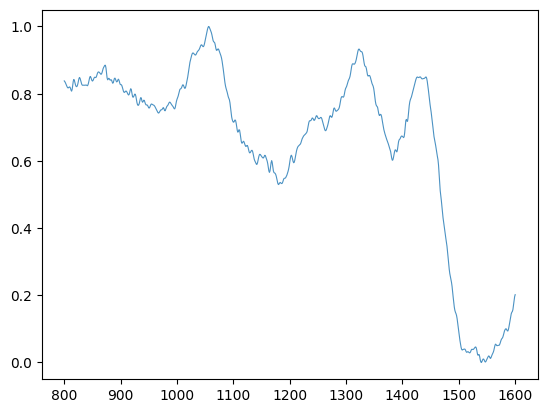

In [18]:
sample = await create_sample(spectrum)
sample.plot()

In [32]:
import pickle
with open("../models/GridSearch-RandomForestRegressor", 'rb') as f:
    model = pickle.load(f)
with open("../models/GridSearch-RandomForestRegressor_pca", 'rb') as f:
    pca = pickle.load(f)

float(model.predict(pca.transform(sample.y.reshape(1,-1)))[0])

118.35059722427489